In [1]:
import json
import pandas as pd
import seaborn as sns
import regex as re

from scripts.analysis import *
from scripts.data_processing import process_trials_from_df

In [40]:
import os

files = os.listdir('./data/fr/')

# print(files)

foi = []
for file in files:
    if file.endswith(".feather") & file.startswith("fr100_"):
        foi.append(os.path.join("./data/fr/", file))
    else:
        continue

print(foi)

['./data/fr/fr100_56210effed6e5a000ac7f3a5.feather', './data/fr/fr100_57313ba2070de6000f43384e.feather', './data/fr/fr100_5962eb69241f8d0001064bd3.feather', './data/fr/fr100_5a455b091950a80001e7c49a.feather', './data/fr/fr100_5ac7a7f1f69e940001d999a7.feather', './data/fr/fr100_5af196e1e1b5b8000148ac76.feather', './data/fr/fr100_5afc4671bb36f900018ef1fe.feather', './data/fr/fr100_5b2caaa75b5c0900018b4724.feather', './data/fr/fr100_5b98d9362cca9c0001de161f.feather', './data/fr/fr100_5cb08ecee11a890001a478ad.feather', './data/fr/fr100_5cd5fe480f0de600018e7251.feather', './data/fr/fr100_5cfb74958f650700151c7df3.feather', './data/fr/fr100_5d230886d7533000017a4409.feather', './data/fr/fr100_5d8a1081323cf30001205f53.feather', './data/fr/fr100_5d99898ab82ce10398fc1556.feather', './data/fr/fr100_5da78f61a60c0d0017d6ed89.feather', './data/fr/fr100_5e6d395882be80000cec9f92.feather', './data/fr/fr100_5ea91fe115728f3d0f6b7d17.feather', './data/fr/fr100_5ebaec011a7d64080694fe74.feather', './data/fr/

In [45]:
# get all DF filenames from data/fr folder

def data_to_df(files: list):
    ''' provide list of feather data file pathnames '''
    dfs = {}  # features of interest
    for path in files:
        try:
            print(path)
            df = pd.read_feather(path)
            uuid = re.findall('(?<=fr100_).*(?=\.feather)', path)[0]
            dfs[uuid] = df
        except PermissionError:
            continue
    return dfs

In [46]:
dfs = data_to_df(foi)

./data/fr/fr100_56210effed6e5a000ac7f3a5.feather
./data/fr/fr100_57313ba2070de6000f43384e.feather
./data/fr/fr100_5962eb69241f8d0001064bd3.feather
./data/fr/fr100_5a455b091950a80001e7c49a.feather
./data/fr/fr100_5ac7a7f1f69e940001d999a7.feather
./data/fr/fr100_5af196e1e1b5b8000148ac76.feather
./data/fr/fr100_5afc4671bb36f900018ef1fe.feather
./data/fr/fr100_5b2caaa75b5c0900018b4724.feather
./data/fr/fr100_5b98d9362cca9c0001de161f.feather
./data/fr/fr100_5cb08ecee11a890001a478ad.feather
./data/fr/fr100_5cd5fe480f0de600018e7251.feather
./data/fr/fr100_5cfb74958f650700151c7df3.feather
./data/fr/fr100_5d230886d7533000017a4409.feather
./data/fr/fr100_5d8a1081323cf30001205f53.feather
./data/fr/fr100_5d99898ab82ce10398fc1556.feather
./data/fr/fr100_5da78f61a60c0d0017d6ed89.feather
./data/fr/fr100_5e6d395882be80000cec9f92.feather
./data/fr/fr100_5ea91fe115728f3d0f6b7d17.feather
./data/fr/fr100_5ebaec011a7d64080694fe74.feather
./data/fr/fr100_5ef7d6c359b38851de122110.feather
./data/fr/fr100_5efd

In [ ]:
uuids = dfs.keys()

In [55]:
def lie_detection_accuracy(uuid, actual_lies, model_pred, prior, alpha, threshold):
    if len(actual_lies) != len(model_pred):
        raise ValueError("Unequal number of predicted and actual data points")
    
    pre = [prior + alpha*v for v in model_pred]
    pred = [1 if v > threshold else 0 for v in pre]
    
    tp = [1 if (x==1) & (y==1) else 0 for x, y in zip(actual_lies, pred)]
    tp = sum(tp)
    
    fp = [1 if (x==0) & (y==1) else 0 for x, y in zip(actual_lies, pred)]
    fp = sum(fp)
    
    tn = [1 if (x==0) & (y==0) else 0 for x, y in zip(actual_lies, pred)]
    tn = sum(tn)
    
    fn = [1 if (x==1) & (y==0) else 0 for x, y in zip(actual_lies, pred)]
    fn = sum(fn)
    
    accuracy = (tp + tn)/len(actual_lies)
    
    if tp+fp == 0:
        precision = 0
    else:
        precision = tp/(tp+fp)
    
    if tp+fn == 0:
        recall = 0
    else:
        recall = tp/(tp+fn)
    
    f1 = tp/(tp+0.5*(fp+fn))
    
    return {"n_subjective_detection": tp+fp, 
                           "tp": tp, 
                           "fp": fp, 
                           "tn": tn, 
                           "fn": fn, 
                           "precision": precision, 
                           "recall": recall, 
                           "accuracy": accuracy, 
                           "f1": f1,
           "uuid": uuid}


def lie_detection_accuracy_opt(uuid, actual_lies, model_pred, prior, alpha, threshold):
    if len(actual_lies) != len(model_pred):
        raise ValueError("Unequal number of predicted and actual data points")
    
    pre = [prior + alpha*v for v in model_pred]
    pred = [1 if v < threshold else 0 for v in pre]
    
    tp = [1 if (x==1) & (y==1) else 0 for x, y in zip(actual_lies, pred)]
    tp = sum(tp)
    
    fp = [1 if (x==0) & (y==1) else 0 for x, y in zip(actual_lies, pred)]
    fp = sum(fp)
    
    tn = [1 if (x==0) & (y==0) else 0 for x, y in zip(actual_lies, pred)]
    tn = sum(tn)
    
    fn = [1 if (x==1) & (y==0) else 0 for x, y in zip(actual_lies, pred)]
    fn = sum(fn)
    
    accuracy = (tp + tn)/len(actual_lies)
    
    if tp+fp == 0:
        precision = 0
    else:
        precision = tp/(tp+fp)
    
    if tp+fn == 0:
        recall = 0
    else:
        recall = tp/(tp+fn)
    
    f1 = tp/(tp+0.5*(fp+fn))
    
    return {"n_subjective_detection": tp+fp, 
                           "tp": tp, 
                           "fp": fp, 
                           "tn": tn, 
                           "fn": fn, 
                           "precision": precision, 
                           "recall": recall, 
                           "accuracy": accuracy, 
                           "f1": f1,
           "uuid": uuid}

In [56]:
dfs = pd.read_feather("./data/fr/fr100_data_long.feather")

In [57]:
uuids = set(dfs['PID'])

In [ ]:
dfs[dfs['PID'] == '5ef7d6c359b38851de122110']

In [58]:
del dfs['index']

In [59]:
dfs.shape

(9000, 26)

In [62]:
n_blue_per_trial = reset_n_blue_per_trial()

In [63]:
# use threshold 0.5

obj_detection_blue_is_lie = []
obj_detection_lied_is_lie = []
obj_detection_col_congruency = [] # detect lie when other player reports different colour from subject's colour pick

obj_detection_sig_ev_noup = []
obj_detection_unsig_ev_noup = []
obj_detection_sig_col_count = []
obj_detection_unsig_col_count = []
obj_detection_sig_ev_up = []
obj_detection_unsig_ev_up = []

obj_detection_optimal_prob = []

for uuid in uuids:
    df = process_trials_from_df(dfs[dfs['PID']==uuid], 7)
    subject_lied = df['col_reported']!=df['col_picked']
    col_congruency = df['outcome']!=df['col_picked']
    
    optimal_p = []
    for row in df.values:
        optimal_p.append(check_lie_prob_signed(n_blue_per_trial, 7, row[1], row[2]))
    n_blue_per_trial = reset_n_blue_per_trial()

    obj_detection_blue_is_lie.append(lie_detection_accuracy(uuid, df['pp_lied'].values, df['outcome'].values, 0, 1, 0.5))
    obj_detection_lied_is_lie.append(lie_detection_accuracy(uuid, df['pp_lied'].values, subject_lied.values, 0, 1, 0.5))
    obj_detection_col_congruency.append(lie_detection_accuracy(uuid, df['pp_lied'].values, col_congruency.values, 0, 1, 0.5))
    
    obj_detection_sig_ev_noup.append(lie_detection_accuracy(uuid, df['pp_lied'].values, df['normed_signed_e_v'].values, 0, 1, 0.5))
    obj_detection_unsig_ev_noup.append(lie_detection_accuracy(uuid, df['pp_lied'].values, df['normed_unsigned_e_v'].values, 0, 1, 0.5))
    
    obj_detection_sig_col_count.append(lie_detection_accuracy(uuid, df['pp_lied'].values, df['normed_signed_colour_count'].values, 0, 1, 0.5))
    obj_detection_unsig_col_count.append(lie_detection_accuracy(uuid, df['pp_lied'].values, df['normed_unsigned_colour_count'].values, 0, 1, 0.5))
    
    obj_detection_sig_ev_up.append(lie_detection_accuracy(uuid, df['pp_lied'].values, df['normed_cs_signed_e_v'].values, 0, 1, 0.5))
    obj_detection_unsig_ev_up.append(lie_detection_accuracy(uuid, df['pp_lied'].values, df['normed_cs_unsigned_e_v'].values, 0, 1, 0.5))
    
    obj_detection_optimal_prob.append(lie_detection_accuracy_opt(uuid, df['pp_lied'].values, optimal_p, 0, 1, 0.05))

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['trial'] = trials.index + 1
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['n_blue'] = n_card_per_trial - trials['n_red']
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

n trials with setup 1
n trials with setup 1
p blue in trial 0.5714285714285714
n trials with setup 1
n trials with setup 1
p blue in trial 0.14285714285714285
n trials with setup 2
n trials with setup 2
n trials with setup 3
n trials with setup 4
n trials with setup 5
n trials with setup 2
n trials with setup 2
n trials with setup 3
n trials with setup 3
n trials with setup 4
n trials with setup 6
n trials with setup 7
n trials with setup 1
p blue in trial 0.42857142857142855
n trials with setup 5
n trials with setup 8
n trials with setup 6
n trials with setup 3
n trials with setup 7
n trials with setup 9
n trials with setup 1
p blue in trial 0.8571428571428571
n trials with setup 8
n trials with setup 9
n trials with setup 4
n trials with setup 2
n trials with setup 2
n trials with setup 3
n trials with setup 4
n trials with setup 5
n trials with setup 10
n trials with setup 6
n trials with setup 11
n trials with setup 5
n trials with setup 12
n trials with setup 6
n trials with setup

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['trial'] = trials.index + 1
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['n_blue'] = n_card_per_trial - trials['n_red']
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

n trials with setup 1
n trials with setup 1
p blue in trial 0.8571428571428571
n trials with setup 2
n trials with setup 1
n trials with setup 1
p blue in trial 0.7142857142857143
n trials with setup 3
n trials with setup 2
n trials with setup 1
n trials with setup 2
n trials with setup 2
n trials with setup 2
n trials with setup 3
n trials with setup 4
n trials with setup 1
p blue in trial 0.5714285714285714
n trials with setup 5
n trials with setup 3
n trials with setup 4
n trials with setup 5
n trials with setup 4
n trials with setup 6
n trials with setup 5
n trials with setup 6
n trials with setup 7
n trials with setup 3
n trials with setup 2
n trials with setup 3
n trials with setup 3
n trials with setup 6
n trials with setup 4
n trials with setup 7
n trials with setup 8
n trials with setup 5
n trials with setup 7
n trials with setup 6
n trials with setup 8
n trials with setup 9
n trials with setup 7
n trials with setup 9
n trials with setup 8
n trials with setup 10
n trials with 

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['normed_signed_e_v'] = normalize(trials['e_v'])
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['normed_unsigned_e_v'] = normalize(abs(trials['e_v']))
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

n trials with setup 1
n trials with setup 2
n trials with setup 1
p blue in trial 0.5714285714285714
n trials with setup 3
n trials with setup 1
n trials with setup 2
n trials with setup 1
p blue in trial 0.2857142857142857
n trials with setup 1
p blue in trial 0.8571428571428571
n trials with setup 4
n trials with setup 5
n trials with setup 2
n trials with setup 1
n trials with setup 2
n trials with setup 3
n trials with setup 6
n trials with setup 7
n trials with setup 4
n trials with setup 8
n trials with setup 9
n trials with setup 2
n trials with setup 2
n trials with setup 5
n trials with setup 6
n trials with setup 7
n trials with setup 3
n trials with setup 3
n trials with setup 8
n trials with setup 3
n trials with setup 9
n trials with setup 4
n trials with setup 5
n trials with setup 10
n trials with setup 4
n trials with setup 5
n trials with setup 10
n trials with setup 6
n trials with setup 11
n trials with setup 3
n trials with setup 7
n trials with setup 11
n trials wi

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['n_consec_colour'] = track_freq
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['normed_signed_colour_count'] = normalized_signed_colour_count
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

 7
n trials with setup 8
n trials with setup 10
n trials with setup 2
n trials with setup 11
n trials with setup 7
n trials with setup 2
n trials with setup 3
n trials with setup 3
n trials with setup 9
n trials with setup 4
n trials with setup 2
n trials with setup 3
n trials with setup 8
n trials with setup 9
n trials with setup 10
n trials with setup 11
n trials with setup 12
n trials with setup 4
n trials with setup 12
n trials with setup 13
n trials with setup 13
n trials with setup 10
n trials with setup 4
n trials with setup 11
n trials with setup 5
n trials with setup 5
n trials with setup 14
n trials with setup 15
n trials with setup 6
n trials with setup 16
n trials with setup 17
n trials with setup 14
n trials with setup 18
n trials with setup 12
n trials with setup 13
n trials with setup 15
n trials with setup 7
n trials with setup 8
n trials with setup 16
n trials with setup 19
n trials with setup 17
n trials with setup 14
n trials with setup 20
n trials with setup 21
n tr

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['normed_signed_colour_count'] = normalized_signed_colour_count
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['normed_unsigned_colour_count'] = normalize(trials['n_consec_colour'])
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:87: SettingWithCopyWarning: 
A value is 

n trials with setup 1
p blue in trial 0.2857142857142857
n trials with setup 1
p blue in trial 0.5714285714285714
n trials with setup 2
n trials with setup 1
p blue in trial 0.14285714285714285
n trials with setup 1
p blue in trial 0.8571428571428571
n trials with setup 1
p blue in trial 0.42857142857142855
n trials with setup 2
n trials with setup 1
n trials with setup 2
n trials with setup 3
n trials with setup 3
n trials with setup 4
n trials with setup 4
n trials with setup 5
n trials with setup 2
n trials with setup 2
n trials with setup 6
n trials with setup 2
n trials with setup 7
n trials with setup 5
n trials with setup 3
n trials with setup 8
n trials with setup 4
n trials with setup 6
n trials with setup 3
n trials with setup 7
n trials with setup 8
n trials with setup 9
n trials with setup 10
n trials with setup 9
n trials with setup 11
n trials with setup 3
n trials with setup 5
n trials with setup 4
n trials with setup 12
n trials with setup 13
n trials with setup 10
n tr

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['trial'] = trials.index + 1
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['n_blue'] = n_card_per_trial - trials['n_red']
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

n trials with setup 1
n trials with setup 1
n trials with setup 2
n trials with setup 2
n trials with setup 3
n trials with setup 1
p blue in trial 0.2857142857142857
n trials with setup 1
p blue in trial 0.5714285714285714
n trials with setup 1
n trials with setup 2
n trials with setup 2
n trials with setup 3
n trials with setup 1
p blue in trial 0.42857142857142855
n trials with setup 3
n trials with setup 4
n trials with setup 2
n trials with setup 4
n trials with setup 4
n trials with setup 3
n trials with setup 5
n trials with setup 5
n trials with setup 3
n trials with setup 4
n trials with setup 5
n trials with setup 6
n trials with setup 2
n trials with setup 6
n trials with setup 4
n trials with setup 7
n trials with setup 6
n trials with setup 7
n trials with setup 8
n trials with setup 7
n trials with setup 8
n trials with setup 5
n trials with setup 9
n trials with setup 10
n trials with setup 9
n trials with setup 5
n trials with setup 11
n trials with setup 3
n trials wit

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['normed_signed_colour_count'] = normalized_signed_colour_count
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['normed_unsigned_colour_count'] = normalize(trials['n_consec_colour'])
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:87: SettingWithCopyWarning: 
A value is 

n trials with setup 1
p blue in trial 0.14285714285714285
n trials with setup 1
n trials with setup 2
n trials with setup 1
n trials with setup 2
n trials with setup 2
n trials with setup 1
n trials with setup 1
p blue in trial 0.8571428571428571
n trials with setup 3
n trials with setup 4
n trials with setup 3
n trials with setup 3
n trials with setup 1
n trials with setup 4
n trials with setup 2
n trials with setup 3
n trials with setup 2
n trials with setup 4
n trials with setup 5
n trials with setup 6
n trials with setup 5
n trials with setup 5
n trials with setup 6
n trials with setup 4
n trials with setup 5
n trials with setup 7
n trials with setup 6
n trials with setup 7
n trials with setup 8
n trials with setup 9
n trials with setup 2
n trials with setup 6
n trials with setup 7
n trials with setup 8
n trials with setup 8
n trials with setup 9
n trials with setup 10
n trials with setup 3
n trials with setup 4
n trials with setup 11
n trials with setup 9
n trials with setup 12
n 

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['n_blue'] = n_card_per_trial - trials['n_red']
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['e_v'] = np.where(trials['outcome'] == -1,
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

n trials with setup 1
p blue in trial 0.8571428571428571
n trials with setup 1
p blue in trial 0.5714285714285714
n trials with setup 1
n trials with setup 1
p blue in trial 0.42857142857142855
n trials with setup 2
n trials with setup 1
p blue in trial 0.2857142857142857
n trials with setup 2
n trials with setup 2
n trials with setup 3
n trials with setup 1
p blue in trial 0.7142857142857143
n trials with setup 2
n trials with setup 4
n trials with setup 2
n trials with setup 5
n trials with setup 3
n trials with setup 3
n trials with setup 2
n trials with setup 4
n trials with setup 4
n trials with setup 3
n trials with setup 4
n trials with setup 5
n trials with setup 5
n trials with setup 3
n trials with setup 5
n trials with setup 6
n trials with setup 6
n trials with setup 6
n trials with setup 6
n trials with setup 7
n trials with setup 7
n trials with setup 7
n trials with setup 8
n trials with setup 8
n trials with setup 4
n trials with setup 7
n trials with setup 8
n trials w

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['n_consec_colour'] = track_freq
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['normed_signed_colour_count'] = normalized_signed_colour_count
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

n trials with setup 1
n trials with setup 3
n trials with setup 4
n trials with setup 4
n trials with setup 2
n trials with setup 1
p blue in trial 0.42857142857142855
n trials with setup 5
n trials with setup 4
n trials with setup 3
n trials with setup 5
n trials with setup 6
n trials with setup 2
n trials with setup 4
n trials with setup 5
n trials with setup 6
n trials with setup 7
n trials with setup 8
n trials with setup 7
n trials with setup 8
n trials with setup 9
n trials with setup 5
n trials with setup 2
n trials with setup 6
n trials with setup 6
n trials with setup 7
n trials with setup 9
n trials with setup 10
n trials with setup 3
n trials with setup 4
n trials with setup 7
n trials with setup 3
n trials with setup 8
n trials with setup 11
n trials with setup 5
n trials with setup 12
n trials with setup 6
n trials with setup 10
n trials with setup 13
n trials with setup 14
n trials with setup 9
n trials with setup 4
n trials with setup 11
n trials with setup 15
n trials w

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['trial'] = trials.index + 1
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['n_blue'] = n_card_per_trial - trials['n_red']
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

n trials with setup 1
p blue in trial 0.14285714285714285
n trials with setup 1
p blue in trial 0.2857142857142857
n trials with setup 2
n trials with setup 3
n trials with setup 1
p blue in trial 0.42857142857142855
n trials with setup 2
n trials with setup 3
n trials with setup 4
n trials with setup 1
p blue in trial 0.7142857142857143
n trials with setup 1
n trials with setup 2
n trials with setup 5
n trials with setup 1
p blue in trial 0.5714285714285714
n trials with setup 6
n trials with setup 2
n trials with setup 4
n trials with setup 7
n trials with setup 8
n trials with setup 3
n trials with setup 5
n trials with setup 6
n trials with setup 9
n trials with setup 3
n trials with setup 4
n trials with setup 7
n trials with setup 8
n trials with setup 9
n trials with setup 5
n trials with setup 10
n trials with setup 11
n trials with setup 12
n trials with setup 2
n trials with setup 6
n trials with setup 7
n trials with setup 10
n trials with setup 13
n trials with setup 4
n tr

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['normed_signed_e_v'] = normalize(trials['e_v'])
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['normed_unsigned_e_v'] = normalize(abs(trials['e_v']))
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

n trials with setup 1
p blue in trial 0.42857142857142855
n trials with setup 1
p blue in trial 0.8571428571428571
n trials with setup 1
p blue in trial 0.14285714285714285
n trials with setup 2
n trials with setup 3
n trials with setup 2
n trials with setup 1
p blue in trial 0.2857142857142857
n trials with setup 3
n trials with setup 4
n trials with setup 1
p blue in trial 0.7142857142857143
n trials with setup 2
n trials with setup 5
n trials with setup 2
n trials with setup 3
n trials with setup 4
n trials with setup 6
n trials with setup 7
n trials with setup 2
n trials with setup 3
n trials with setup 3
n trials with setup 5
n trials with setup 6
n trials with setup 8
n trials with setup 4
n trials with setup 5
n trials with setup 9
n trials with setup 4
n trials with setup 6
n trials with setup 4
n trials with setup 5
n trials with setup 1
n trials with setup 6
n trials with setup 7
n trials with setup 2
n trials with setup 3
n trials with setup 10
n trials with setup 8
n trials

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['normed_signed_colour_count'] = normalized_signed_colour_count
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['normed_unsigned_colour_count'] = normalize(trials['n_consec_colour'])
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:87: SettingWithCopyWarning: 
A value is 


n trials with setup 3
n trials with setup 6
n trials with setup 7
n trials with setup 4
n trials with setup 3
n trials with setup 8
n trials with setup 6
n trials with setup 9
n trials with setup 10
n trials with setup 4
n trials with setup 5
n trials with setup 11
n trials with setup 4
n trials with setup 7
n trials with setup 12
n trials with setup 5
n trials with setup 6
n trials with setup 13
n trials with setup 8
n trials with setup 14
n trials with setup 15
n trials with setup 6
n trials with setup 5
n trials with setup 6
n trials with setup 5
n trials with setup 7
n trials with setup 7
n trials with setup 8
n trials with setup 16
n trials with setup 7
n trials with setup 9
n trials with setup 8
n trials with setup 8
n trials with setup 9
n trials with setup 10
n trials with setup 9
n trials with setup 11
n trials with setup 17
n trials with setup 12
n trials with setup 10
n trials with setup 10
n trials with setup 11
n trials with setup 18
n trials with setup 12
n trials with s

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['normed_unsigned_colour_count'] = normalize(trials['n_consec_colour'])
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['trial'] = trials.index + 1
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

n trials with setup 1
p blue in trial 0.7142857142857143
n trials with setup 2
n trials with setup 1
p blue in trial 0.8571428571428571
n trials with setup 1
n trials with setup 2
n trials with setup 1
n trials with setup 2
n trials with setup 1
p blue in trial 0.5714285714285714
n trials with setup 3
n trials with setup 2
n trials with setup 2
n trials with setup 3
n trials with setup 3
n trials with setup 1
n trials with setup 4
n trials with setup 4
n trials with setup 5
n trials with setup 5
n trials with setup 3
n trials with setup 4
n trials with setup 3
n trials with setup 2
n trials with setup 3
n trials with setup 4
n trials with setup 4
n trials with setup 4
n trials with setup 5
n trials with setup 5
n trials with setup 6
n trials with setup 5
n trials with setup 6
n trials with setup 6
n trials with setup 5
n trials with setup 6
n trials with setup 6
n trials with setup 7
n trials with setup 7
n trials with setup 7
n trials with setup 7
n trials with setup 7
n trials with s

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['trial'] = trials.index + 1
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['n_blue'] = n_card_per_trial - trials['n_red']
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

n trials with setup 1
p blue in trial 0.2857142857142857
n trials with setup 1
n trials with setup 1
n trials with setup 2
n trials with setup 3
n trials with setup 4
n trials with setup 1
p blue in trial 0.7142857142857143
n trials with setup 2
n trials with setup 3
n trials with setup 4
n trials with setup 1
n trials with setup 2
n trials with setup 3
n trials with setup 2
n trials with setup 5
n trials with setup 4
n trials with setup 6
n trials with setup 5
n trials with setup 5
n trials with setup 6
n trials with setup 6
n trials with setup 7
n trials with setup 7
n trials with setup 2
n trials with setup 3
n trials with setup 8
n trials with setup 1
p blue in trial 0.5714285714285714
n trials with setup 9
n trials with setup 3
n trials with setup 8
n trials with setup 10
n trials with setup 11
n trials with setup 4
n trials with setup 5
n trials with setup 12
n trials with setup 13
n trials with setup 4
n trials with setup 2
n trials with setup 14
n trials with setup 15
n trials 

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['trial'] = trials.index + 1
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['n_blue'] = n_card_per_trial - trials['n_red']
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

n trials with setup 1
p blue in trial 0.14285714285714285
n trials with setup 1
n trials with setup 1
n trials with setup 2
n trials with setup 1
p blue in trial 0.42857142857142855
n trials with setup 3
n trials with setup 2
n trials with setup 2
n trials with setup 1
p blue in trial 0.7142857142857143
n trials with setup 2
n trials with setup 3
n trials with setup 1
p blue in trial 0.8571428571428571
n trials with setup 2
n trials with setup 3
n trials with setup 4
n trials with setup 5
n trials with setup 2
n trials with setup 4
n trials with setup 5
n trials with setup 3
n trials with setup 3
n trials with setup 6
n trials with setup 6
n trials with setup 7
n trials with setup 7
n trials with setup 8
n trials with setup 4
n trials with setup 9
n trials with setup 10
n trials with setup 11
n trials with setup 8
n trials with setup 12
n trials with setup 5
n trials with setup 3
n trials with setup 4
n trials with setup 4
n trials with setup 9
n trials with setup 5
n trials with setup

C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['trial'] = trials.index + 1
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['n_blue'] = n_card_per_trial - trials['n_red']
C:\Users\Sarah Zheng\dev\simpy-suspicion-model\scripts\data_processing.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u


n trials with setup 7
n trials with setup 8
n trials with setup 4
n trials with setup 9
n trials with setup 10
n trials with setup 11
n trials with setup 8
n trials with setup 12
n trials with setup 5
n trials with setup 3
n trials with setup 4
n trials with setup 4
n trials with setup 9
n trials with setup 5
n trials with setup 4
n trials with setup 13
n trials with setup 6
n trials with setup 5
n trials with setup 6
n trials with setup 7
n trials with setup 14
n trials with setup 15
n trials with setup 10
n trials with setup 11
n trials with setup 7
n trials with setup 16
n trials with setup 5
n trials with setup 12
n trials with setup 8
n trials with setup 9
n trials with setup 13
n trials with setup 8
n trials with setup 14
n trials with setup 17
n trials with setup 6
n trials with setup 9
n trials with setup 15
n trials with setup 10
n trials with setup 6
n trials with setup 16
n trials with setup 17
n trials with setup 18
n trials with setup 19
n trials with setup 20
n trials wi

n trials with setup 6
n trials with setup 14
n trials with setup 7
n trials with setup 7
n trials with setup 3
n trials with setup 15
n trials with setup 8
n trials with setup 8
n trials with setup 16
n trials with setup 9
n trials with setup 17
n trials with setup 10
n trials with setup 18
n trials with setup 8
n trials with setup 19
n trials with setup 9
n trials with setup 6
n trials with setup 20
n trials with setup 21
n trials with setup 4
n trials with setup 11
n trials with setup 9
n trials with setup 12
n trials with setup 5
n trials with setup 22
n trials with setup 13
n trials with setup 6
n trials with setup 14
n trials with setup 7
n trials with setup 8
n trials with setup 9
n trials with setup 15
n trials with setup 23
n trials with setup 10
n trials with setup 11
n trials with setup 10
n trials with setup 7
n trials with setup 11
n trials with setup 10
n trials with setup 11
n trials with setup 16
n trials with setup 17
n trials with setup 18
n trials with setup 19
n tria

In [66]:
pd.DataFrame(obj_detection_blue_is_lie)

,n_subjective_detection,tp,fp,tn,fn,precision,recall,accuracy,f1,uuid
0,47,13,34,43,0,0.276596,1.000000,0.622222,0.433333,616b05332ad106da01d79fa8
1,58,17,41,30,2,0.293103,0.894737,0.522222,0.441558,612812ff639db35356dff7c5
2,55,21,34,35,0,0.381818,1.000000,0.622222,0.552632,615f4e20d504f648ffd22972
3,59,23,36,30,1,0.389831,0.958333,0.588889,0.554217,616d53892b58b6e0388ab050
4,54,25,29,35,1,0.462963,0.961538,0.666667,0.625000,5cfb74958f650700151c7df3
...,...,...,...,...,...,...,...,...,...,...
95,66,26,40,24,0,0.393939,1.000000,0.555556,0.565217,5af196e1e1b5b8000148ac76
96,55,21,34,32,3,0.381818,0.875000,0.588889,0.531646,613bea209464d339e18036d4
97,52,19,33,38,0,0.365385,1.000000,0.633333,0.535211,6160f30a9b243350dd593650
98,60,16,44,30,0,0.266667,1.000000,0.511111,0.421053,5b2caaa75b5c0900018b4724


<AxesSubplot:ylabel='precision'>

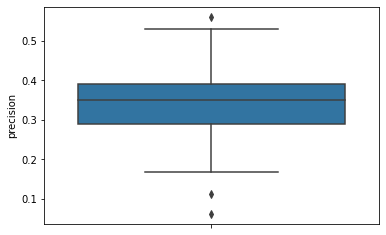

In [67]:
sns.boxplot(data=pd.DataFrame(obj_detection_blue_is_lie), y="precision")

In [69]:
pd.DataFrame(obj_detection_blue_is_lie).std()

n_subjective_detection    6.396843
tp                        5.762742
fp                        5.285113
tn                        6.251392
fn                        0.985296
precision                 0.085627
recall                    0.065579
accuracy                  0.057961
f1                        0.098875
dtype: float64

In [71]:
pd.DataFrame(obj_detection_lied_is_lie).mean() #.apply(lambda x: sum(x)/len(x))

n_subjective_detection    20.850000
tp                         5.260000
fp                        15.590000
tn                        53.510000
fn                        15.640000
precision                  0.213728
recall                     0.257742
accuracy                   0.653000
f1                         0.190184
dtype: float64

In [23]:
pd.DataFrame(obj_detection_lied_is_lie).std()

n_subjective_detection    19.814480
tp                         5.679344
fp                        14.961293
tn                        14.998650
fn                         7.193600
precision                  0.180049
recall                     0.254674
accuracy                   0.115003
f1                         0.154817
dtype: float64

In [73]:
pd.DataFrame(obj_detection_col_congruency).mean() #.apply(lambda x: sum(x)/len(x))

n_subjective_detection    39.660000
tp                        13.710000
fp                        25.950000
tn                        43.150000
fn                         7.190000
precision                  0.345129
recall                     0.650570
accuracy                   0.631778
f1                         0.443843
dtype: float64

In [25]:
pd.DataFrame(obj_detection_col_congruency).std()

n_subjective_detection    5.065670
tp                        4.511030
fp                        5.019910
tn                        5.509175
fn                        2.855776
precision                 0.105047
recall                    0.121773
accuracy                  0.055925
f1                        0.109014
dtype: float64

In [26]:
pd.DataFrame(obj_detection_sig_col_count).apply(lambda x: sum(x)/len(x))

n_subjective_detection    28.990000
tp                         9.750000
fp                        19.240000
tn                        49.860000
fn                        11.150000
precision                  0.342395
recall                     0.488815
accuracy                   0.662333
f1                         0.366682
dtype: float64

In [27]:
pd.DataFrame(obj_detection_sig_col_count).std()

n_subjective_detection    14.016941
tp                         5.455745
fp                        10.378805
tn                         8.774412
fn                         7.102959
precision                  0.114501
recall                     0.276728
accuracy                   0.066101
f1                         0.129512
dtype: float64

In [28]:
pd.DataFrame(obj_detection_unsig_col_count).apply(lambda x: sum(x)/len(x))

n_subjective_detection    15.120000
tp                         4.520000
fp                        10.600000
tn                        58.500000
fn                        16.380000
precision                  0.309943
recall                     0.216074
accuracy                   0.700222
f1                         0.238805
dtype: float64

In [29]:
pd.DataFrame(obj_detection_unsig_col_count).std()

n_subjective_detection    5.924235
tp                        2.532536
fp                        4.996969
tn                        5.791844
fn                        4.966107
precision                 0.137654
recall                    0.105567
accuracy                  0.051441
f1                        0.097854
dtype: float64

In [30]:
pd.DataFrame(obj_detection_sig_ev_noup).apply(lambda x: sum(x)/len(x))

n_subjective_detection    57.010000
tp                        19.700000
fp                        37.310000
tn                        31.790000
fn                         1.200000
precision                  0.343276
recall                     0.936013
accuracy                   0.572111
f1                         0.496983
dtype: float64

In [31]:
pd.DataFrame(obj_detection_sig_ev_noup).std()

n_subjective_detection    6.307755
tp                        5.744563
fp                        5.325174
tn                        6.199210
fn                        0.974420
precision                 0.086363
recall                    0.064986
accuracy                  0.058678
f1                        0.099545
dtype: float64

In [32]:
pd.DataFrame(obj_detection_unsig_ev_noup).apply(lambda x: sum(x)/len(x))

n_subjective_detection    44.670000
tp                        17.810000
fp                        26.860000
tn                        42.240000
fn                         3.090000
precision                  0.395045
recall                     0.846911
accuracy                   0.667222
f1                         0.532705
dtype: float64

In [33]:
pd.DataFrame(obj_detection_unsig_ev_noup).std()

n_subjective_detection    5.395574
tp                        5.186803
fp                        4.429059
tn                        5.574328
fn                        1.583341
precision                 0.096195
recall                    0.080629
accuracy                  0.047044
f1                        0.099779
dtype: float64

In [34]:
pd.DataFrame(obj_detection_sig_ev_up).apply(lambda x: sum(x)/len(x))

n_subjective_detection    46.180000
tp                        10.700000
fp                        35.480000
tn                        33.620000
fn                        10.200000
precision                  0.234760
recall                     0.512143
accuracy                   0.492444
f1                         0.313397
dtype: float64

In [35]:
pd.DataFrame(obj_detection_sig_ev_up).std()

n_subjective_detection    9.506383
tp                        3.718640
fp                        8.904068
tn                        8.487400
fn                        3.393398
precision                 0.076492
recall                    0.107092
accuracy                  0.081065
f1                        0.079731
dtype: float64

In [36]:
pd.DataFrame(obj_detection_unsig_ev_up).apply(lambda x: sum(x)/len(x))

n_subjective_detection    46.220000
tp                        10.630000
fp                        35.590000
tn                        33.510000
fn                        10.270000
precision                  0.231371
recall                     0.508858
accuracy                   0.490444
f1                         0.312209
dtype: float64

In [74]:
pd.DataFrame(obj_detection_unsig_ev_up).mean()

n_subjective_detection    46.220000
tp                        10.630000
fp                        35.590000
tn                        33.510000
fn                        10.270000
precision                  0.231371
recall                     0.508858
accuracy                   0.490444
f1                         0.312209
dtype: float64

In [37]:
pd.DataFrame(obj_detection_unsig_ev_up).std()

n_subjective_detection    2.687720
tp                        3.427916
fp                        4.675522
tn                        3.998725
fn                        3.180925
precision                 0.076778
recall                    0.084380
accuracy                  0.048983
f1                        0.081924
dtype: float64

In [38]:
pd.DataFrame(obj_detection_optimal_prob).apply(lambda x: sum(x)/len(x))

n_subjective_detection    17.780000
tp                         9.380000
fp                         8.400000
tn                        60.700000
fn                        11.520000
precision                  0.521605
recall                     0.428439
accuracy                   0.778667
f1                         0.453000
dtype: float64

In [47]:
pd.DataFrame(obj_detection_optimal_prob).std()

n_subjective_detection    8.267717
tp                        5.092637
fp                        4.287638
tn                        8.205074
fn                        3.647277
precision                 0.160088
recall                    0.162317
accuracy                  0.053896
f1                        0.142288
dtype: float64

In [82]:
df = pd.DataFrame(obj_detection_optimal_prob).set_index('uuid')
df.reset_index().to_feather("./data/fr/fr100_lie_detect_model_optimalprob.feather")